In [ ]:
!pip install Wand

In [ ]:
!sudo apt-get install libmagickwand-dev

In [ ]:
import os
from PIL import Image
import os.path
import time
import torch
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch.utils.data as data
import numpy as np

import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings

In [ ]:
# import data path
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/'


Mounted at /content/drive


We have conducted experiments on the robustness of motion blur, color space, CAE and EDSR augmentations. This document shows the first half part of each models in the experiments -- Data Augmentation.

For each model, we have a sample part and an actual implementation part.

# Color Space

We have prepared augmentation methods for brightness, contrast and saturation. But because of the limited time, we only conducted experiments on contrast augmentation (severity = 2 and severity = 3).

## Sample

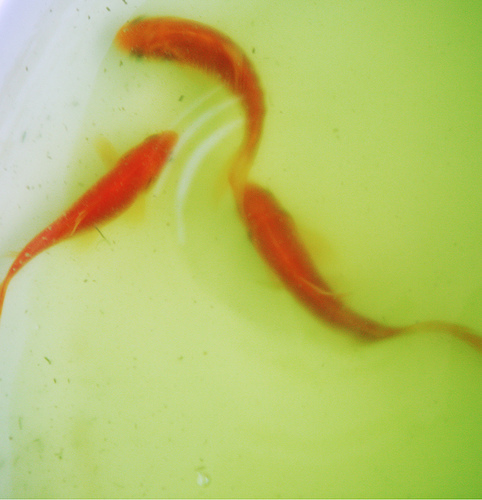

In [ ]:
# Read a sample image
img2 = Image.open(data_path+'pre_contrast_sample1.JPEG')
input2 = img2.convert('RGB')
img2 # Show Images

In [ ]:
def contrast(x, severity=1):
    c = [1.1, 1.2, 1.3, 1.4, 1.5] [severity-1]
    x = np.array(x) / 255.
    return np.clip((x - 128.0/255.0) * c + 128.0/255.0, 0, 1) * 255.

RGB


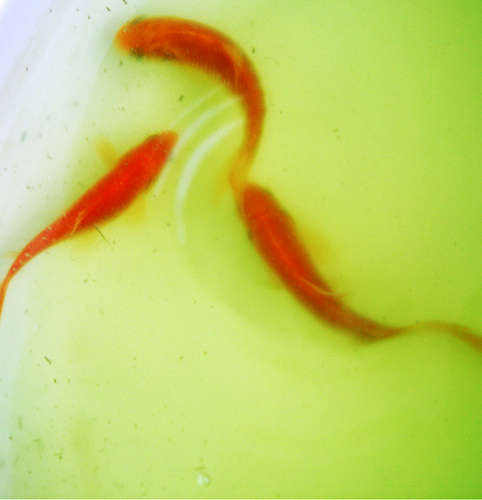

In [ ]:
im_out2 = contrast(input2, 2)
im_out2 = im_out2.astype(np.uint8)
pil_img2 = Image.fromarray(im_out2)
print(pil_img2.mode)# RGB
pil_img2.save(data_path+'after_contrast_sample1_2.JPEG')
pil_img2

RGB


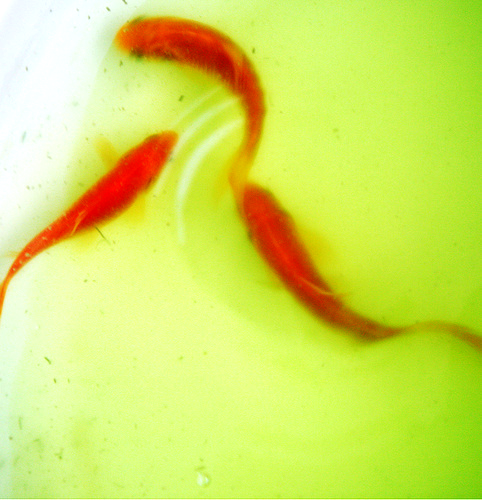

In [ ]:
im_out2 = contrast(input2, 5)
im_out2 = im_out2.astype(np.uint8)
pil_img2 = Image.fromarray(im_out2)
print(pil_img2.mode)# RGB
pil_img2.save(data_path+'after_contrast_sample1_5.JPEG')
pil_img2

## Actual Data Augmentation

In [ ]:
# /////////////// Data Loader ///////////////


IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']


def is_image_file(filename):
    """Checks if a file is an image.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)
    return images


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class DistortImageFolder(data.Dataset):
    def __init__(self, root, method, severity, transform=None, target_transform=None,
                 loader=default_loader):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise (RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                                                                             "Supported image extensions are: " + ",".join(
                IMG_EXTENSIONS)))

        self.root = root
        self.method = method
        self.severity = severity
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
            img = self.method(img, self.severity)
        if self.target_transform is not None:
            target = self.target_transform(target)
        # /home/jtang/Desktop/DistortedImageNet/JPEG/
        save_path = '/data/imagenet_augment_contrast/' + self.method.__name__ + \
                    '/' + str(self.severity) + '/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        Image.fromarray(np.uint8(img)).save(save_path, quality=85, optimize=True)

        return 0  # we do not care about returning the data

    def __len__(self):
        return len(self.imgs)


# /////////////// Distortion Helpers ///////////////
warnings.simplefilter("ignore", UserWarning)




# Tell Python about the C method
wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle


# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)



# /////////////// Distortions ///////////////

def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

'''
    c = [0.4, .3, .2, .1, .05][severity - 1]
    # c = 2.0
    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255.
'''
def contrast(x, severity=1):
    c = [1.1, 1.2, 1.3, 1.4, 1.5] [severity-1]
    x = np.array(x) / 255.
    return np.clip((x - 128.0/255.0) * c + 128.0/255.0, 0, 1) * 255.



# /////////////////////////////////////////////
# /data/imagenet/ILSVRC/Data/CLS-LOC/real_train
# /home/jtang/Desktop/val
def save_distorted(method=gaussian_noise):
    for severity in range(3, 4):# HERE can modify the severity of augmentation
        #severity = 0
        print(method.__name__, severity)
        distorted_dataset = DistortImageFolder(
            root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train",
            method=method, severity=severity,
            transform=trn.Compose([trn.Resize(256), trn.CenterCrop(224)]))
        distorted_dataset_loader = torch.utils.data.DataLoader(
            distorted_dataset, batch_size=100, shuffle=False, num_workers=4)

        for _ in distorted_dataset_loader: continue


# /////////////// Display Results ///////////////
print('\nUsing ImageNet data')
save_distorted(contrast)


Using ImageNet data
contrast 3



To save time of data augmentation, we only generate datasets after contrast augmentation with severity = 2 and severity = 3.

The code above is generating datasets after contrast augmentation with severity = 3. The severity can be manually modified in the `save_distorted(method=gaussian_noise)` function